# Quantium Virtual Internship - Retail Strategy and Analytics - Task 1

## Load required libraries and datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# load datasets
transaction_data = pd.read_csv(r'D:\REGINA\DA DS\quantium_retail\QVI_transaction_data.csv')
customer_data = pd.read_csv(r'D:\REGINA\DA DS\quantium_retail\QVI_purchase_behaviour.csv')

## Exploratory data analysis
The first step in any analysis is to first understand the data. Let’s take a look at each of the datasets provided.

### Examine transaction data

In [4]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [5]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


We can see that the date column is in an integer format. Let’s change this to a date format.

In [6]:
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], origin='1899-12-30', unit='D')
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


We should check that we are looking at the right products by examining PROD_NAME

In [7]:
transaction_data['PROD_NAME'].describe()

count                                     264836
unique                                       114
top       Kettle Mozzarella   Basil & Pesto 175g
freq                                        3304
Name: PROD_NAME, dtype: object

We should check that we are looking at the right products by examining PROD_NAME.


In [8]:
unique_product = transaction_data.groupby('PROD_NAME').agg(N=('PROD_NAME','size')).reset_index()
unique_product

,PROD_NAME,N
0,Burger Rings 220g,1564
1,CCs Nacho Cheese 175g,1498
2,CCs Original 175g,1514
3,CCs Tasty Cheese 175g,1539
4,Cheetos Chs & Bacon Balls 190g,1479
...,...,...
109,WW Sour Cream &OnionStacked Chips 160g,1483
110,WW Supreme Cheese Corn Chips 200g,1509
111,Woolworths Cheese Rings 190g,1516
112,Woolworths Medium Salsa 300g,1430


Looks like we are definitely looking at potato chips but how can we check that these are all chips? We can
do some basic text analysis by summarising the individual words in the product name.

In [9]:
word = [word for product in unique_product['PROD_NAME'] for word in product.split()]
word = pd.DataFrame(word, columns=['word'])
word

,word
0,Burger
1,Rings
2,220g
3,CCs
4,Nacho
...,...
584,300g
585,Woolworths
586,Mild
587,Salsa


In [10]:
# Removing digits and special characters
unique_word = word[word['word'].str.match(r'^[a-zA-Z]+$')]

In [11]:
# Sorting distinct unique words
pd.DataFrame(unique_word.value_counts()).sort_values('count', ascending=False).reset_index()

,word,count
0,Chips,21
1,Smiths,16
2,Crinkle,14
3,Cut,14
4,Kettle,13
...,...,...
163,Snbts,1
164,SourCream,1
165,Southern,1
166,Sp,1


There are salsa products in the dataset but we are only interested in the chips category, so let’s remove these.

In [12]:
# Removing salsa products
# salsa_product = transaction_data[transaction_data['PROD_NAME'].str.lower().str.contains('salsa')].index
# transaction_data.drop(salsa_product, axis='index', inplace=True)
# transaction_data

In [13]:
# Summarise the data to check for nulls and possible outliers
transaction_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264836,264836.00000,2.648360e+05,2.648360e+05,264836.000000,264836.000000,264836.000000
mean,2018-12-30 00:52:12.879215616,135.08011,1.355495e+05,1.351583e+05,56.583157,1.907309,7.304200
min,2018-07-01 00:00:00,1.00000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,2018-09-30 00:00:00,70.00000,7.002100e+04,6.760150e+04,28.000000,2.000000,5.400000
50%,2018-12-30 00:00:00,130.00000,1.303575e+05,1.351375e+05,56.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.00000,2.030942e+05,2.027012e+05,85.000000,2.000000,9.200000
max,2019-06-30 00:00:00,272.00000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.78418,8.057998e+04,7.813303e+04,32.826638,0.643654,3.083226


In [14]:
# Check for nulls
transaction_data.isna().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

There are no nulls in the columns but product quantity appears to have an outlier which we should investigate further. Let’s investigate further the case where 200 packets of chips are bought in one transaction.

In [15]:
# Filter the dataset to find the outlier
transaction_data[transaction_data['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


There are two transactions where 200 packets of chips are bought in one transaction and both of these transactions where by the same customer

In [16]:
# Check if the customer has had other transactions
transaction_data[transaction_data['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


It looks like this customer has only had the two transactions over the year and is not an ordinary retail customer. The customer might be buying chips for commercial purposes instead. We’ll remove this loyalty card number from further analysis.

In [17]:
# Filter transaction made not by retail customer
commercial_cust = transaction_data['LYLTY_CARD_NBR'] == 226000
transaction_data = transaction_data[~commercial_cust]
transaction_data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [18]:
# Re-examine transaction data
transaction_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264834,264834.000000,2.648340e+05,2.648340e+05,264834.000000,264834.000000,264834.000000
mean,2018-12-30 00:52:10.292938240,135.079423,1.355488e+05,1.351576e+05,56.583554,1.905813,7.299346
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,2018-09-30 00:00:00,70.000000,7.002100e+04,6.760050e+04,28.000000,2.000000,5.400000
50%,2018-12-30 00:00:00,130.000000,1.303570e+05,1.351365e+05,56.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030940e+05,2.026998e+05,85.000000,2.000000,9.200000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000
std,NaN,76.784063,8.057990e+04,7.813292e+04,32.826444,0.343436,2.527241


In [19]:
# Count the number of transactions by date
date_transaction = transaction_data.groupby('DATE').agg(num_of_transactions=('DATE','count')).sort_values('DATE', ascending=False).reset_index()
date_transaction

,DATE,num_of_transactions
0,2019-06-30,744
1,2019-06-29,745
2,2019-06-28,730
3,2019-06-27,709
4,2019-06-26,723
...,...,...
359,2018-07-05,712
360,2018-07-04,714
361,2018-07-03,722
362,2018-07-02,711


There’s only 364 rows, meaning only 364 dates which indicates a missing date. Let’s create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a chart of number of transactions over time to find the missing date.

In [20]:
# Create a column of dates that includes every day from 1 Jul 2018 to 30 Jun 2019
all_date = pd.DataFrame(pd.date_range('2018-07-01', '2019-06-30'), columns=['date'])
all_transaction_date = all_date.merge(date_transaction, how='left', left_on='date', right_on='DATE')
all_transaction_date.drop('DATE', axis='columns', inplace=True)
all_transaction_date

,date,num_of_transactions
0,2018-07-01,724.0
1,2018-07-02,711.0
2,2018-07-03,722.0
3,2018-07-04,714.0
4,2018-07-05,712.0
...,...,...
360,2019-06-26,723.0
361,2019-06-27,709.0
362,2019-06-28,730.0
363,2019-06-29,745.0


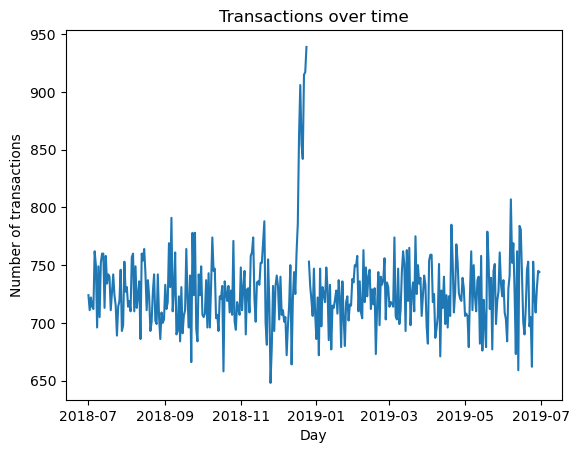

In [21]:
# Plot transactions over time
plt.plot(all_transaction_date['date'], all_transaction_date['num_of_transactions'])
plt.title('Transactions over time')
plt.xlabel('Day')
plt.ylabel('Number of transactions')
plt.show()

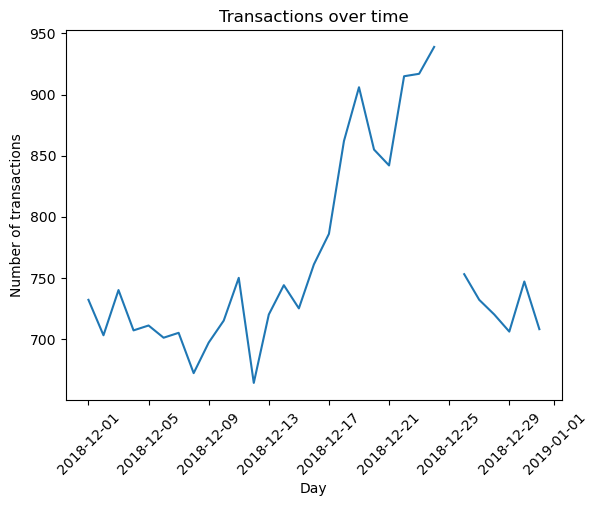

In [22]:
# Zoom plot to December
december_transaction = all_transaction_date[all_transaction_date['date'].dt.month == 12]
plt.plot(december_transaction['date'], december_transaction['num_of_transactions'])
plt.xticks(rotation=45)
plt.title('Transactions over time')
plt.xlabel('Day')
plt.ylabel('Number of transactions')
plt.show()

We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on Christmas day itself. This is due to shops being closed on Christmas day.

Now that we are satisfied that the data no longer has outliers, we can move on to creating other features such as brand of chips or pack size from PROD_NAME. We will start with pack size.

In [23]:
# Create PACK_SIZE column
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract(r'(\d+)').astype('int')
transaction_data[transaction_data['PACK_SIZE'] == 300]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
5,2019-05-19,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1,300
25,2019-05-15,39,39144,35506,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1,300
63,2019-05-15,82,82480,82047,101,Doritos Salsa Medium 300g,1,2.6,300
71,2018-08-15,94,94233,93956,65,Old El Paso Salsa Dip Chnky Tom Ht300g,1,5.1,300
74,2018-08-16,97,97159,97271,35,Woolworths Mild Salsa 300g,5,7.5,300
...,...,...,...,...,...,...,...,...,...
264655,2018-08-30,264,264440,263237,41,Doritos Salsa Mild 300g,1,2.6,300
264663,2018-08-24,265,265018,263318,101,Doritos Salsa Medium 300g,1,2.6,300
264675,2019-04-20,265,265103,263419,59,Old El Paso Salsa Dip Tomato Med 300g,1,5.1,300
264678,2019-03-30,265,265111,263428,35,Woolworths Mild Salsa 300g,1,1.5,300


In [24]:
# Check PACK_SIZE
transaction_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PACK_SIZE
count,264834,264834.000000,2.648340e+05,2.648340e+05,264834.000000,264834.000000,264834.000000,264834.000000
mean,2018-12-30 00:52:10.292938240,135.079423,1.355488e+05,1.351576e+05,56.583554,1.905813,7.299346,182.425512
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000,70.000000
25%,2018-09-30 00:00:00,70.000000,7.002100e+04,6.760050e+04,28.000000,2.000000,5.400000,150.000000
50%,2018-12-30 00:00:00,130.000000,1.303570e+05,1.351365e+05,56.000000,2.000000,7.400000,170.000000
75%,2019-03-31 00:00:00,203.000000,2.030940e+05,2.026998e+05,85.000000,2.000000,9.200000,175.000000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000,380.000000
std,NaN,76.784063,8.057990e+04,7.813292e+04,32.826444,0.343436,2.527241,64.325148


In [25]:
# Check if the pack sizes look sensible
transaction_pack = transaction_data.groupby('PACK_SIZE').agg(N=('PACK_SIZE', 'count')).reset_index()
transaction_pack

,PACK_SIZE,N
0,70,1507
1,90,3008
2,110,22387
3,125,1454
4,134,25102
5,135,3257
6,150,43131
7,160,2970
8,165,15297
9,170,19983


The largest size is 380g and the smallest size is 70g - seems sensible!

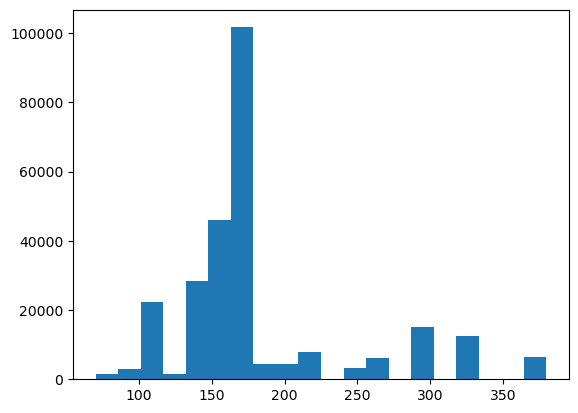

In [26]:
# Plot a histogram of PACK_SIZE
plt.hist(transaction_pack['PACK_SIZE'], weights=transaction_pack['N'], bins=20)
plt.show()

Pack sizes created look reasonable and now to create brands, we can use the first word in PROD_NAME to work out the brand name.

In [27]:
# Create BRAND_NAME column
transaction_data['BRAND_NAME'] = transaction_data['PROD_NAME'].str.split().str[0].str.upper()

In [28]:
# Check brands
pd.DataFrame(transaction_data['BRAND_NAME'].unique())

,0
0,NATURAL
1,CCS
2,SMITHS
3,KETTLE
4,OLD
5,GRAIN
6,DORITOS
7,TWISTIES
8,WW
9,THINS


Some of the brand names look like they are of the same brands - such as RED and RRD, which are both Red Rock Deli chips. Let’s combine these together.

In [29]:
# Clean brand names
transaction_data['BRAND_NAME'] = transaction_data['BRAND_NAME'].str.replace('RED', 'RRD')
transaction_data['BRAND_NAME'] = transaction_data['BRAND_NAME'].str.replace('SNBTS', 'SUNBITES')
transaction_data['BRAND_NAME'] = transaction_data['BRAND_NAME'].str.replace('INFZNS', 'INFUZIONS')
transaction_data['BRAND_NAME'] = transaction_data['BRAND_NAME'].str.replace('WW', 'WOOLWORTHS')
transaction_data['BRAND_NAME'] = transaction_data['BRAND_NAME'].str.replace('SMITH', 'SMITHS')
transaction_data['BRAND_NAME'] = transaction_data['BRAND_NAME'].str.replace('SMITHSS', 'SMITHS')
transaction_data['BRAND_NAME'] = transaction_data['BRAND_NAME'].str.replace('NCC', 'NATURAL')
transaction_data['BRAND_NAME'] = transaction_data['BRAND_NAME'].str.replace('DORITO', 'DORITOS')
transaction_data['BRAND_NAME'] = transaction_data['BRAND_NAME'].str.replace('DORITOSS', 'DORITOS')
transaction_data['BRAND_NAME'] = transaction_data['BRAND_NAME'].str.replace('GRAIN', 'GRNWVES')

In [30]:
# Recheck brand names
transaction_data.groupby('BRAND_NAME').agg(N=('BRAND_NAME','count')).reset_index()
# pd.DataFrame(transaction_data['BRAND_NAME'].unique())

,BRAND_NAME,N
0,BURGER,1564
1,CCS,4551
2,CHEETOS,2927
3,CHEEZELS,4603
4,COBS,9693
5,DORITOS,28145
6,FRENCH,1418
7,GRNWVES,7740
8,INFUZIONS,14201
9,KETTLE,41288


### Examining customer data

In [31]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


Let’s have a closer look at the LIFESTAGE and PREMIUM_CUSTOMER columns.

In [32]:
customer_data['LIFESTAGE'].value_counts()

LIFESTAGE
RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: count, dtype: int64

In [33]:
customer_data['PREMIUM_CUSTOMER'].value_counts()

PREMIUM_CUSTOMER
Mainstream    29245
Budget        24470
Premium       18922
Name: count, dtype: int64

As there do not seem to be any issues with the customer data, we can now go ahead and join the transaction and customer data sets together.

In [34]:
# Merge transaction data with customer data
data = transaction_data.merge(customer_data, on='LYLTY_CARD_NBR', how='left')
data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,SMITHS,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,SMITHS,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,KETTLE,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175,KETTLE,YOUNG SINGLES/COUPLES,Premium
264830,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175,TOSTITOS,YOUNG SINGLES/COUPLES,Premium
264831,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170,DORITOS,YOUNG SINGLES/COUPLES,Premium
264832,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150,DORITOS,YOUNG SINGLES/COUPLES,Premium


Let’s also check if some customers were not matched on by checking for nulls.

In [35]:
data.isna().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND_NAME          0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

Okay, there are no nulls! So all our customers in the transaction data has been accounted for in the customer dataset.

In [36]:
data.to_csv(r'D:\REGINA\DA DS\quantium_retail\data.csv', index=False)

## Data analysis on customer segments

Now that the data is ready for analysis, we can define some metrics of interest to the client:
• Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is
• How many customers are in each segment
• How many chips are bought per customer by segment
• What’s the average chip price by customer segment

We could also ask our data team for more information. Examples are:
• The customer’s total spend over the period and total spend for each transaction to understand whatproportion of their grocery spend is on chips
• Proportion of customers in each customer segment overall to compare against the mix of customers who purchase chips

Let’s start with calculating total sales by LIFESTAGE and PREMIUM_CUSTOMER and plotting the split by these segments to describe which customer segment contribute most to chip sales.

In [37]:
# Total sales by LIFESTAGE and PREMIUM_CUSTOMER
total_sales = data['TOT_SALES'].sum()
cust_total_sales = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({'TOT_SALES':'sum'}).sort_values('TOT_SALES', ascending=False).reset_index()
cust_total_sales['PCTG'] = cust_total_sales['TOT_SALES']/total_sales

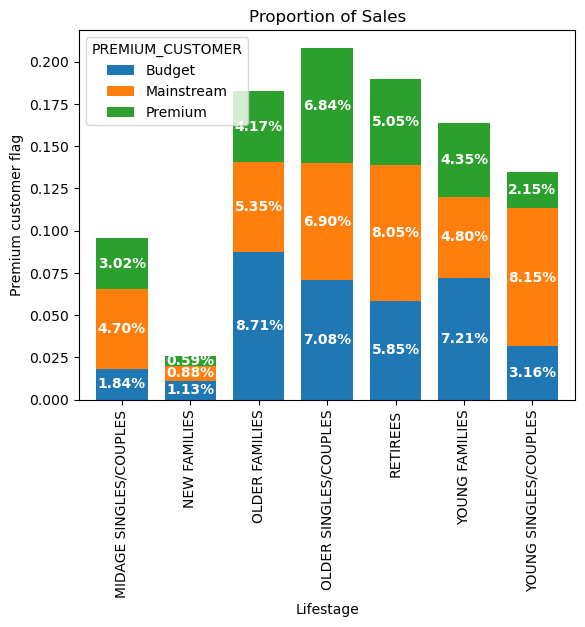

In [38]:
pivot_df = cust_total_sales.pivot_table(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='PCTG')
ax = pivot_df.plot(kind='bar', stacked=True, width=0.75)
for i in range(len(pivot_df)):
    cumulative_height = 0
    for j in range(len(pivot_df.columns)):
        height = pivot_df.iloc[i, j]
        if height > 0:
            cumulative_height += height
            ax.text(i, cumulative_height - height / 2, f'{height:.2%}', 
                    ha='center', va='center', color='white', fontweight='bold')
plt.title('Proportion of Sales')
plt.xlabel('Lifestage')
plt.ylabel('Premium customer flag')
plt.show()

Sales are coming mainly from Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees.

Let’s see if the higher sales are due to there being more customers who buy chips.

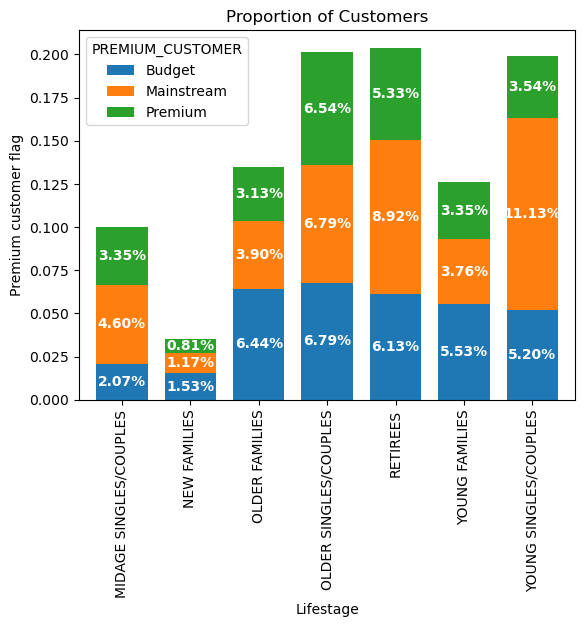

In [39]:
# Number of customers by LIFESTAGE and PREMIUM_CUSTOMER
total_cust = data['LYLTY_CARD_NBR'].nunique()
num_of_cust = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(cust_num=('LYLTY_CARD_NBR','nunique')).reset_index()
num_of_cust['percentage'] = num_of_cust['cust_num']/total_cust
pivot_df = num_of_cust.pivot_table(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='percentage')
ax = pivot_df.plot(kind='bar', stacked=True, width=0.75)
for i in range(len(pivot_df)):
    cumulative_height = 0
    for j in range(len(pivot_df.columns)):
        height = pivot_df.iloc[i, j]
        if height > 0:
            cumulative_height += height
            ax.text(i, cumulative_height - height / 2, f'{height:.2%}', 
                    ha='center', va='center', color='white', fontweight='bold')
plt.title('Proportion of Customers')
plt.xlabel('Lifestage')
plt.ylabel('Premium customer flag')
plt.show()

There are more Mainstream - young singles/couples and Mainstream - retirees who buy chips. This contributes to there being more sales to these customer segments but this is not a major driver for the Budget - Older families segment.

Higher sales may also be driven by more units of chips being bought per customer. Let’s have a look at this next.

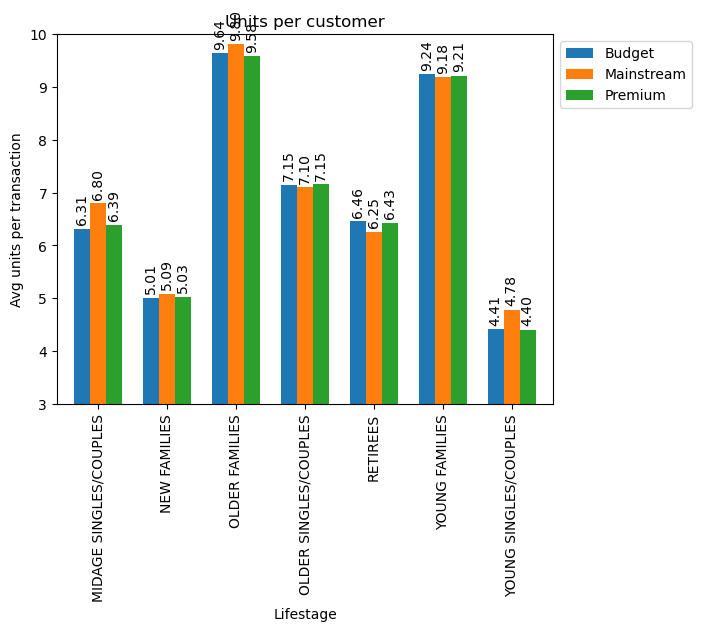

In [40]:
# Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
avg_unit = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(total_unit=('PROD_QTY','sum'), \
                                                               total_cust=('LYLTY_CARD_NBR', 'nunique')).reset_index()
avg_unit['avg_unit'] = avg_unit['total_unit']/avg_unit['total_cust']
pivot_df = avg_unit.pivot_table(index='LIFESTAGE', values='avg_unit', columns='PREMIUM_CUSTOMER')
ax = pivot_df.plot(kind='bar', width=0.7)
plt.ylim([3, 10])
for container in ax.containers:
    ax.bar_label(container, rotation=90, labels=[f'{val:.2f}' for val in container.datavalues], padding=3)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title('Units per customer')
plt.xlabel('Lifestage')
plt.ylabel('Avg units per transaction')
plt.show()

Older families and young families in general buy more chips per customer.

Let’s also investigate the average price per unit chips bought for each customer segment as this is also a driver of total sales.

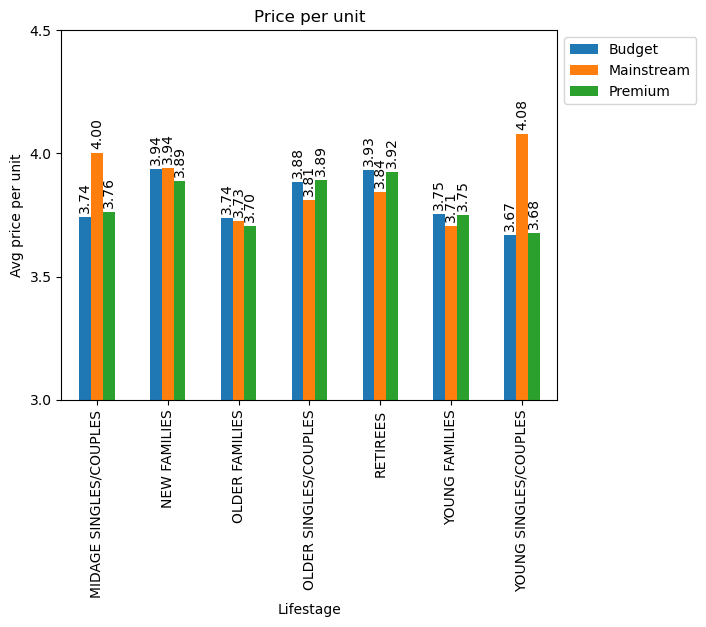

In [41]:
# Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER
avg_price = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(total_price=('TOT_SALES', 'sum'),\
                                                               total_unit=('PROD_QTY', 'sum')).reset_index()
avg_price['avg_price'] = avg_price['total_price']/avg_price['total_unit']
pivot_df = avg_price.pivot_table(index='LIFESTAGE', values='avg_price', columns='PREMIUM_CUSTOMER')
ax = pivot_df.plot(kind='bar')
plt.ylim([3, 4.5])
plt.yticks([3.0, 3.5, 4.0, 4.5])
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
for container in ax.containers:
    ax.bar_label(container, rotation=90, labels=[f'{val:.2f}' for val in container.datavalues], padding=3)
plt.title('Price per unit')
plt.xlabel('Lifestage')
plt.ylabel('Avg price per unit')
plt.show()

Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own
consumption. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.

As the difference in average price per unit isn’t large, we can check if this difference is statistically different.

In [42]:
# Perform an independent t‐test between mainstream vs premium and budget midage and young singles and couples
data['price_per_unit'] = data['TOT_SALES']/data['PROD_QTY']
filtered_df = data[data['LIFESTAGE'].isin(['MIDAGE SINGLES/COUPLES', 'YOUNG SINGLES/COUPLES'])]
mainstream = filtered_df[filtered_df['PREMIUM_CUSTOMER'] == 'Mainstream']['price_per_unit']
non_mainstream = filtered_df[filtered_df['PREMIUM_CUSTOMER'] != 'Mainstream']['price_per_unit']

print('mean of x:', mainstream.mean(), 'mean of y:', non_mainstream.mean())

t_stat, p_val = stats.ttest_ind(mainstream, non_mainstream, alternative='greater', equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_val}")
if p_val < 0.05:
    print("The mean price per unit for Mainstream customers is significantly higher than non-Mainstream customers.")
else:
    print("There is no significant difference in price per unit between Mainstream and non-Mainstream customers.")

mean of x: 4.045586042532388 mean of y: 3.688165443861052
T-statistic: 40.60989476220132, P-value: 0.0
The mean price per unit for Mainstream customers is significantly higher than non-Mainstream customers.


The t-test results shows that the unit price for mainstream, young and mid-age singles and couples are significantly higher than that of budget or premium, young and midage singles and couples.

We might want to target customer segments that contribute the most to sales to retain them or further increase sales. Let's look at Mainstream - young singles/couples. For instance, let's find out if they tend to buy a particular brand of chips.

In [44]:
# Deep dive into Mainstream, young singles/couples
target_segment = data[(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & \
                                        (data['PREMIUM_CUSTOMER'] == 'Mainstream')]
other_segment =  data[~(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & \
                                        (data['PREMIUM_CUSTOMER'] == 'Mainstream')]

In [51]:
# Brand affinity compared to the rest of the population
quantity_target_segment = target_segment['PROD_QTY'].sum()
quantity_other_segment = other_segment['PROD_QTY'].sum()

brand_tsegment = target_segment.groupby('BRAND_NAME').agg(qty_brand_tsegment=('PROD_QTY','sum'))
brand_tsegment['proportion_tsegment'] = brand_tsegment['qty_brand_tsegment']/quantity_target_segment

brand_osegment = other_segment.groupby('BRAND_NAME').agg(qty_brand_osegment=('PROD_QTY','sum'))
brand_osegment['proportion_osegment'] = brand_osegment['qty_brand_osegment']/quantity_other_segment

affinity_brand = brand_tsegment.merge(brand_osegment, on='BRAND_NAME', how='left')
affinity_brand['affinity_to_brand'] = affinity_brand['proportion_tsegment'] / affinity_brand['proportion_osegment']

affinity_brand.reset_index(inplace=True)
affinity_brand.sort_values('affinity_to_brand', ascending=False)

,BRAND_NAME,qty_brand_tsegment,proportion_tsegment,qty_brand_osegment,proportion_osegment,affinity_to_brand
19,TYRRELLS,1143,0.029587,3756,0.024180,1.223594
18,TWISTIES,1673,0.043306,5533,0.035620,1.215771
17,TOSTITOS,1645,0.042581,5493,0.035363,1.204129
12,PRINGLES,4326,0.111980,14535,0.093573,1.196708
9,KETTLE,7172,0.185649,24162,0.155550,1.193504
11,OLD,1607,0.041598,5484,0.035305,1.178243
5,DORITOS,4747,0.122877,16610,0.106932,1.149122
8,INFUZIONS,2343,0.060649,8241,0.053054,1.143165
4,COBS,1617,0.041856,5847,0.037642,1.111971
16,THINS,2187,0.056611,8215,0.052886,1.070429


We can see that :
- Mainstream young singles/couples are 22% more likely to purchase Tyrrells chips compared to the rest of the population.
- Mainstream young singles/couples are 55% less likely to purchase Burger Rings compared to the rest of the population.

Let’s also find out if our target segment tends to buy larger packs of chips.

In [56]:
# Preferred pack size compared to the rest of the population
pack_tsegment = target_segment.groupby('PACK_SIZE').agg(qty_pack_tsegment=('PROD_QTY','sum'))
pack_tsegment['proportion_tsegment'] = pack_tsegment['qty_pack_tsegment']/quantity_target_segment

pack_osegment = other_segment.groupby('PACK_SIZE').agg(qty_pack_osegment=('PROD_QTY','sum'))
pack_osegment['proportion_osegment'] = pack_osegment['qty_pack_osegment']/quantity_other_segment

affinity_pack = pack_tsegment.merge(pack_osegment, on='PACK_SIZE', how='left')
affinity_pack['affinity_to_pack'] = affinity_pack['proportion_tsegment']/affinity_pack['proportion_osegment']
affinity_pack.reset_index(inplace=True)
affinity_pack.sort_values('affinity_to_pack', ascending=False)

,PACK_SIZE,qty_pack_tsegment,proportion_tsegment,qty_pack_osegment,proportion_osegment,affinity_to_pack
17,270,1153,0.029846,3691,0.023762,1.256035
20,380,1165,0.030156,3732,0.024026,1.255165
19,330,2220,0.057465,7211,0.046423,1.237867
4,134,4326,0.111980,14535,0.093573,1.196708
2,110,3850,0.099658,13210,0.085043,1.171857
14,210,1055,0.027309,3728,0.024000,1.137871
16,250,520,0.013460,1842,0.011858,1.135090
5,135,535,0.013849,1958,0.012605,1.098646
9,170,2926,0.075740,11866,0.076391,0.991486
10,175,9237,0.239102,38555,0.248209,0.963312


It looks like Mainstream young singles/couples are 25% more likely to purchase a 270g pack of chips compared to the rest of the population but let’s dive into what brands sell this pack size.

In [61]:
pd.DataFrame(data[data['PACK_SIZE'] == 270]['PROD_NAME'].unique())

,0
0,Twisties Cheese 270g
1,Twisties Chicken270g


Twisties are the only brand offering 270g packs and so this may instead be reflecting a higher likelihood of
purchasing Twisties.

## Conclusion

Sales have mainly been due to Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees shoppers. We found that the high spend in chips for mainstream young singles/couples and retirees is due to there being more of them than other buyers. Mainstream, midage and young singles and couples are also more likely to pay more per packet of chips. This is indicative of impulse buying behaviour. We’ve also found that Mainstream young singles and couples are 23% more likely to purchase Tyrrells chips compared to the rest of the population. The Category Manager may want to increase the category’s performance by off-locating some Tyrrells and smaller packs of chips in discretionary space near segments where young singles and couples frequent more often to increase visibilty and impulse behaviour.